# Homework 5

Oh hey. This is another coding assignment. We will have two coding problems. The first is to implement the actor critic algorithm. The second is to implement the upper confidence bound algorithm.


In [17]:
import math
import numpy as np
import numpy.random as rnd
import gym
import matplotlib.pyplot as plt
import torch as pt
from tqdm import tqdm
%matplotlib inline
# may require installing Box2D - from terminal:
# pip3 install Box2D

# Fix libiomp5md.dll error
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

# A Value Function Network

The code below creates a neural network that can be used to do temporal difference learning for value functions.

In [2]:
class ValueNetwork(pt.nn.Module):
    """
    This is a neural network
    
    nX - dimension of state
    nH - number of units in the hidden layers
    nL - number of total layers. (must be at least two)
    learningRate - gradient descent step size
    nonlinearity - a nonlinear function used between layers (using "tanh" activation function)
    """
    def __init__(self,nX,nH,nL=2,learningRate=1e-2,nonlinearity=pt.tanh,gamma = 1.):
        """
        The __init__ function sets up the network
        """
        
        super(ValueNetwork,self).__init__()
        # Define the linear layers. These hold the parameters
        # nY = number of output layer
        nY = 1
        self.inputLin = pt.nn.Linear(nX,nH)
        self.outputLin = pt.nn.Linear(nH,nY)
        self.hiddenLin = [pt.nn.Linear(nH,nH) for _ in range(nL-2)]
        
        # The nonlinear function
        self.nl = nonlinearity
        
        
        # Optimization Parameters
        self.gamma = gamma
        self.lr = learningRate
        
    def forward(self,x):
        """
        The forward function computes the value of the neural network
        """
        
        h = self.nl(self.inputLin(x))
        for layer in self.hiddenLin:
            h = self.nl(layer(h))
        
        y = self.outputLin(h)
        return y
    
    
    def optimizer_step(self,x,x_next,c,done,info):
        """
        This function computes the temporal difference update rule
        """
        V = self.forward(x)
        V_next = self.forward(x_next)
        
        if (not done) or ('TimeLimit.truncated' in info.keys()):
            V_pred = c + self.gamma * V_next
        else:
            V_pred = c
        
        tdError = pt.sum(V_pred - V).detach().clone()
        
        # These following steps compute the gradient with respect to the parameters
        loss = V.sum()
        # We must clear all of the current gradient values
        self.zero_grad()
        # This actually computes the gradient
        loss.backward()
        
        # This loop executes the temporal difference learning rule
        # over all of the parameters
        for p in self.parameters():
            # Each parameter has a corresponding data vector
            # and a grad vector.
            
            # the data vector the current value of the parameter
            # the grad vector is the gradient of the loss
            # with respect to the parameter
            p.data = p.data + self.lr * tdError * p.grad
        
        return tdError

# A Policy Network (Not completed, only ideas in comment) for Q1


In [4]:
# Policy Network 
class PolicyNetwork(pt.nn.Module):
    """
    This is a neural network
    
    nX - dimension of state
    nH - number of units in the hidden layers
    nL - number of total layers. (must be at least two)
    learningRate - gradient descent step size
    nonlinearity - a nonlinear function used between layers (using "tanh" activation function)
    """
    def __init__(self,nX,nH,nL=2,learningRate=1e-2,nonlinearity=pt.tanh,gamma = 1.):
        """
        The __init__ function sets up the network
        """
        
        super(PolicyNetwork,self).__init__()
        # Define the linear layers. These hold the parameters
        # nY = number of output layer
        nY = 1
        self.inputLin = pt.nn.Linear(nX,nH)
        self.outputLin = pt.nn.Linear(nH,nY)
        self.hiddenLin = [pt.nn.Linear(nH,nH) for _ in range(nL-2)]
        
        # The nonlinear function
        self.nl = nonlinearity
        
        
        # Optimization Parameters
        self.gamma = gamma
        self.lr = learningRate
        
    def forward(self,x):
        """
        The forward function computes the value of the neural network
        """
        
        h = self.nl(self.inputLin(x))
        for layer in self.hiddenLin:
            h = self.nl(layer(h))
        
        y = self.outputLin(h)
        return y
    
    # ==== modify here =====
    # use output from forward function + gaussian noise => actual action
    def action(self,x):
        
        h = self.nl(self.inputLin(x))
        for layer in self.hiddenLin:
            h = self.nl(layer(h))
        
        y = self.outputLin(h)
    return y

    # ==== modify here =====
    def optimizer_step(self,x,u, tdError, (gamma**step)):
        """
        This function computes the temporal difference update rule
        """
        V = self.forward(x)
        V_next = self.forward(x_next)
        
        if (not done) or ('TimeLimit.truncated' in info.keys()):
            V_pred = c + self.gamma * V_next
        else:
            V_pred = c
        
        tdError = pt.sum(V_pred - V).detach().clone()
        
        # These following steps compute the gradient with respect to the parameters
        loss = V.sum()
        # We must clear all of the current gradient values
        self.zero_grad()
        # This actually computes the gradient
        loss.backward()
        
        # This loop executes the temporal difference learning rule
        # over all of the parameters
        for p in self.parameters():
            # Each parameter has a corresponding data vector
            # and a grad vector.
            
            # the data vector the current value of the parameter
            # the grad vector is the gradient of the loss
            # with respect to the parameter
            p.data = p.data + self.lr * tdError * p.grad
        
        return tdError


# Estimating the Value of a Randomized Policy

The code below shows how the value network can be used to estimate the expected reward from a policy given by complete randomization. The temporal difference error will never go to zero completely, due to the fact that the future rewards depend on the randomly generated inputs. It does do a good enough job to be used in an actor-critic algorithm.

The simulation below just gives 100 episodes in the interest of time. It doesn't look like much is happening, but learning is going on. 

100%|██████████| 100/100 [00:13<00:00,  7.52it/s]


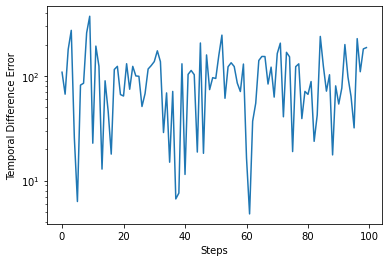

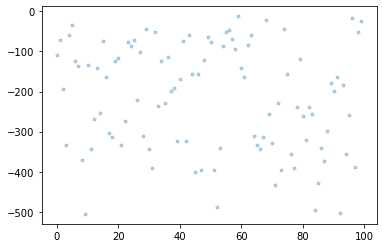

In [29]:
env = gym.make('LunarLanderContinuous-v2')

nH_value = 10000            # num of Hidden Layer
nL_value = 2                # num of total Layer
lr_value = 1e-4             # learning rate
gamma = 1
step = 0
# I in book = (gamma**step)

nS = env.observation_space.shape[0]

# Obtain the value from: ValueNetwork function
V = ValueNetwork(nS,nH_value,nL=nL_value,learningRate=lr_value,nonlinearity=pt.nn.Tanh(),gamma=gamma)

# Obtain the value from: PolicyNetwork function
pi = PolicyNetwork(nS,nH_value,nL=nL_value,learningRate=lr_value,nonlinearity=pt.nn.Tanh(),gamma=gamma)

# Should be "epoch" as terminology in Neural Network
NumEpisodes = int(1e4)

EpTDErrors = []
EpRewards = []
render = False

# tqdm: progress bar / ep: epoch
for ep in tqdm(range(NumEpisodes)):
    s = env.reset()       #initialize s (first state)
    
    EpReward = []
    EpTDError = []
    
    # see training progress with images
    if render:
        env.render()
    done = False

    # 1 iteration
    while not done:
        # Cast the state: s to a pytorch tensor
        x = pt.tensor(s,dtype=pt.float)
        
        # Generate a random action (depend on env of model you choose)
        a = env.action_space.sample()  
        
        # Take action_a would get s_next, immediate rewards,...
        s_next,r,done,info = env.step(a)
        
        # Cast the next state
        x_next = pt.tensor(s_next,dtype=pt.float)
        if render:
            env.render()
            
        # Get TD error from <x & x_next & r>
        # optimizer: https://pytorch.org/docs/master/optim.html#taking-an-optimization-step
        tdErr = V.optimizer_step(x,x_next,r,done,info)
        
        ##### Add on ############ Update policy parameter: theta
        # u = pi.action(x)
        # detach the computational graph in tensor, based on the value of this tensor in a numpy array
        # a = pt.tanh(u).detach().numpy()            
        # pi.optimizer_step(self,x,u, tdErr, (gamma**step))
        
        ##### Add on ############ Compute correction for value
        
        # Record reward & error
        EpReward.append(r)        
        EpTDError.append(tdErr)
        
        # Update state s
        s = np.copy(s_next)        
        step += 1
        
    # Current Reward = sum of 1 episode rewards
    CurReward = np.sum(EpReward)
    CurEpTD = np.sum(EpTDError)
    
    # Record Total Rewards in every episode
    EpRewards.append(CurReward)
    EpTDErrors.append(CurEpTD)
    
    if render:
        env.close()
        
# semilogy is a log plots
plt.semilogy(np.abs(EpTDErrors))
plt.xlabel('Steps')
plt.ylabel('Temporal Difference Error')
    
plt.figure()
plt.plot(EpRewards,'.',alpha=.3)

# Coding Question 1

Implement a network that produces a randomized policy of the form:

$$
A = \phi(S,\theta) + \sigma W.
$$

Here $S$ is the state, $A$ is the action, $W$ is Gaussian noise with mean $0$ and covariance $I$, $\sigma$ is a variance parameter,  and $\theta$ are the neural network parameters.

Use that policy network and the value network to solve the lunar lander problem via the actor critic method. In my copy of Sutton and Barto's book, it is called "One-step Actor–Critic (episodic)" and is on the top of page 332. 

By solve the problem, I mean "gently lands the vehicle near the goal most of the time". I don't have a specific number or reward level I want you to hit. Just learn it well enough so that the system isn't crashing or flying out of the screen.

Hints and notes:
* My solution used the value network exactly as above
* My solution takes a few thousand episodes to nicely solve it
* The policy network should have two closely related functions:
    * `forward(self,x)` which computes the neural network output 
    * `action(self,x)` which adds some gaussian noise to the output of `forward(self,x)`, and is the actual action you compute.
* You will need to calculate $\nabla_\theta \log \pi_\theta(u|x)$, where $\pi_\theta$ is the probability of taking action $u$ given state $x$. You need to take care to ensure that you are not actually differentiating $u$, since its computation actually depends on the neural network parameters. You can make PyTorch treat $u$ as just a normal vector independent of the neural network by using the command `u_detached = u.detach().clone()`. Then work with `u_detached` instead of `u` when computing the gradients.
* I used `pt.tanh` after computing the actions to force it to be in the action space, $[-1,1]^2$. The code looks something like:
```
u = pi.action(x)
# This is the actual action plugged into the step function
# detach the computational graph in tensor, based on the value of this tensor in a numpy array
# https://stackoverflow.com/questions/63582590/why-do-we-call-detach-before-calling-numpy-on-a-pytorch-tensor
a = pt.tanh(u).detach().numpy()
#
# Some code goes here
#
# The policy update uses the original u:
pi.optimizer_step(x,u,tdErr* (gamma**step))
# The gamma**step plays the role of I from the book.
```
It may still work without passing through `pt.tanh`,  but I have not tested this extensively.
* Since this system basically always either lands, crashes, or leaves the window, we can be pretty sure that a terminal state will be reached. So, it is okay to take a discount factor of $\gamma=1$.


# === Down Below is Q2 ===

# Upper Confidence Bound Algorithm

# Solving Bandit Problems with $\epsilon$-greedy.

The code here defines an agent that does $\epsilon$-greedy for multi-armed bandits.

Here is a simulation of the $\epsilon$-greedy method on a bandit problem with $10$ arms.

In [71]:
class epsilon_greedy_agent:
    """
    This defines an agent that performs epsilon-greedy for multi-armed bandits.
    
    agent = epsilon_greedy_agent(K,epsilon)
    
    K - number of arms
    epsilon - probability of randomizing the actions
    Counts - Represent recorded times when arm was pulled.
    
    """
    def __init__(self,K,epsilon = .1):
        self.Q = np.zeros(K)
        self.epsilon = epsilon
        self.K  = K
        
        # Do a Laplace approximation
        self.counts = np.zeros(K)
        self.rewards = np.zeros(K)
        self.Q = np.inf * np.ones(K)
        
    def action(self):
        # If prob is not in epsilon, do exploitation of best arm so far
        if rnd.rand() < self.epsilon:
            i = rnd.randint(self.K)
            
        # If prob falls in epsilon range, do exploration
        else:
            i = np.argmax(self.Q)
            
        return i
    
    # Choose to update chosen arm and reward
    def update(self,i,r):        
        self.counts[i] = self.counts[i] + 1                # update counts pulled for chosen arm
        self.rewards[i] = self.rewards[i] + r              # update average/mean value/reward for chosen arm
        
        self.Q[i] = self.rewards[i] / self.counts[i]

# Coding Question 2

Code up the upper confidence bound (UCB) algorithm from Chapter 7 of the book by Lattimore and Szepesvari, which is on the canvas page. Compare your results with $\epsilon$-greedy. 

What you'll find is: For any fixed value of $\epsilon$, for a small number steps $\epsilon$-greedy will do well, and perhaps better than UCB. As the number of steps gets large, the UCB will start to do much better. Try it out and plot a comparison of the two.

In [68]:
class UpperConfidenceBound_agent:
    """
    This defines an agent that performs epsilon-greedy for multi-armed bandits.
    
    agent = epsilon_greedy_agent(K,epsilon)
    
    K - number of arms
    epsilon - probability of randomizing the actions
    Counts - Represent recorded times when arm was pulled.
    
    """
    def __init__(self,K):
        self.Q = np.zeros(K)
        self.K  = K
        
        # Do a Laplace approximation
        self.counts = np.zeros(K)
        self.rewards = np.zeros(K)
        self.Q = np.inf * np.ones(K)
        
    def action(self):
        # Get the best action
        i = np.argmax(self.Q)        
        return i
    
    # Choose to update chosen arm and reward
    def update(self,i,r):        
        mu_hat_i = np.zeros(K)
        c_value = np.sqrt((2 * np.log(self.counts[i])) / self.counts[i])
        mu_hat_i = self.rewards[i] / self.counts[i]
        self.Q[i] = mu_hat_i + c_value
        
        self.counts[i] = self.counts[i] + 1                # update counts pulled for chosen arm
        self.rewards[i] = self.rewards[i] + r              # update average/mean value/reward for chosen arm
        


  0%|          | 0/10000 [00:00<?, ?it/s]<ipython-input-68-a0bbc2075aa5>:29: RuntimeWarning: divide by zero encountered in log
  c_value = np.sqrt((2 * np.log(self.counts[i])) / self.counts[i])
<ipython-input-68-a0bbc2075aa5>:29: RuntimeWarning: invalid value encountered in sqrt
  c_value = np.sqrt((2 * np.log(self.counts[i])) / self.counts[i])
<ipython-input-68-a0bbc2075aa5>:30: RuntimeWarning: invalid value encountered in double_scalars
  mu_hat_i = self.rewards[i] / self.counts[i]
100%|██████████| 10000/10000 [00:00<00:00, 65380.72it/s]


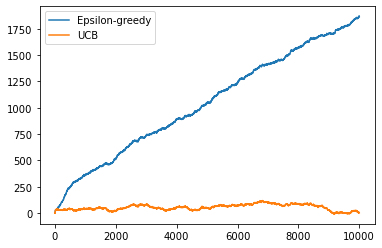

In [72]:
K = 10                        # K bandits ( K lever to pull )
mu = rnd.randn(K)             # random mean (ex. [0.1 0.2 0.6 3])

NumSteps = int(1e4)


agent1 = epsilon_greedy_agent(K)
agent2 = UpperConfidenceBound_agent(K)


# This is a sequence of random rewards
Rewards = np.outer(np.ones(NumSteps),mu) + rnd.randn(NumSteps,K)

AgentRewards1 = []
AgentRewards2 = []

for step in tqdm(range(NumSteps)):
    
    i1 = agent1.action()        # choose action (choose the best value from i-th lever, think as multi-bandit)
    r1 = Rewards[step,i1]    
    agent1.update(i1,r1)         # observe reward & update UCB    
    AgentRewards1.append(r1)
    
    i2 = agent2.action()        # choose action (choose the best value from i-th lever, think as multi-bandit)
    r2 = Rewards[step,i2]    
    agent2.update(i2,r2)         # observe reward & update UCB    
    AgentRewards2.append(r2)
        
        

bestMu = np.max(mu)

Regret1 = bestMu * np.arange(1,NumSteps+1) - np.cumsum(AgentRewards1)
Regret2 = bestMu * np.arange(1,NumSteps+1) - np.cumsum(AgentRewards2)

plt.plot(Regret1,label = 'Epsilon-greedy')  
plt.legend(loc='upper left')

plt.plot(Regret2,label = 'UCB')  
plt.legend(loc='upper left')